# Experiment 1: Late-fusion

### Text + Audio
- Best TER model on MELD:
- Best SER model on MELD:

### Text + Audio + Image
- Best TER model on MELD:
- Best SER model on MELD:
- Deepface

In [1]:
import os, sys
import pandas as pd
import librosa
import torch
import numpy as np

from tqdm import tqdm
tqdm.pandas()
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.data_loading import filter_emotions, load_meld
from src.fusion import LateFusion

#meld_train = load_meld(split='train')
#meld_val = load_meld(split='dev')
meld_test = filter_emotions(load_meld(split='test'))  # smaller subset for testing


fusion = LateFusion(weights={'text': 0.3, 'audio': 0.4, 'video': 0.3})

preds = {
    'text': {'happy': 0.7, 'sad': 0.2, 'neutral': 0.1},
    'audio': 'neutral',
    'video': [
        {'happy': 0.4, 'neutral': 0.6},
        {'happy': 0.3, 'neutral': 0.7}
    ]
}

label, probs, top3 = fusion.fuse(preds)
print("Final label:", label)
print("Probabilities:", probs)
print("Top-3:", top3)

/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Subfolders in the dataset: ['JSON files', 'MELD.Raw']
Subfolders in the raw data: ['dia47_utt11.mp4', 'dia35_utt2.mp4', 'dia47_utt9.mp4', 'dia167_utt14.mp4', 'dia232_utt4.mp4', '._dia118_utt11.mp4', 'dia34_utt2.mp4', 'dia268_utt8.mp4', 'dia233_utt4.mp4', '._dia39_utt1.mp4', '._dia230_utt3.mp4', 'dia137_utt0.mp4', '._dia268_utt11.mp4', '._dia231_utt3.mp4', 'dia136_utt0.mp4', '._dia38_utt1.mp4', '._dia34_utt16.mp4', '._dia128_utt2.mp4', 'dia28_utt7.mp4', 'dia195_utt8.mp4', 'dia22_utt15.mp4', '._dia129_utt2.mp4', '._dia100_utt5.mp4', 'dia29_utt7.mp4', 'dia103_utt2.mp4', 'final_videos_testdia48_utt3.mp4', 'dia154_utt12.mp4', '._dia95_utt11.mp4', '._dia205_utt1.mp4', 'dia102_utt2.mp4', 'dia107_utt8.mp4', 'dia253_utt11.mp4', '._dia52_utt5.mp4', 'dia175_utt3.mp4', 'dia93_utt0.mp4', '._dia272_utt0.mp4', '._dia192_utt5.mp4', 'dia174_utt3.mp4', '._dia53_utt5.mp4', 'dia175_utt13.mp4', 'dia92_utt0.mp4', 'dia191_utt2.mp4', 'dia77_utt1.mp4', 'dia259_utt0.mp4', 'dia270_utt7.mp4', 'dia123_utt11.mp4', 

## MELD

In [2]:
from src.processor import FileProcessor
from src.recognizers import TextEmotionRecognizer, SpeechEmotionRecognizer, FaceEmotionRecognizer

#model = "/Users/krazmic/Documents/GitHub/Repos/EmoReA/emorea-backend/notebooks/multimodal/logreg_E.joblib"
#model = "/Users/krazmic/Documents/GitHub/Repos/EmoReA/emorea-backend/notebooks/speech/logreg_C.joblib"
#model = "/Users/krazmic/Documents/GitHub/Repos/EmoReA/emorea-backend/notebooks/multimodal/rf_C_FS.joblib"
model = "/Users/krazmic/Documents/GitHub/Repos/EmoReA/emorea-backend/notebooks/speech/svm_C.joblib"

fp = FileProcessor()
text_recognizer = TextEmotionRecognizer("gemma2")
audio_recognizer = SpeechEmotionRecognizer(model_path=model)
vision_recognizer = FaceEmotionRecognizer()

def process_files(filename):

    file_data = fp.process_file(filename)
    return file_data

def ser(file_data):

    audio_emo = audio_recognizer.analyze(file_data["audio"]['raw'], 16000)
    return audio_emo

def ter(file_data):

    text_emo = text_recognizer.analyze(file_data["text"])
    return text_emo

def fer(file_data):
    face_emo = vision_recognizer.analyze_video_frames(file_data["frames"])
    return face_emo



def multimodal_er(
        filename,
        fp=fp,
        text_recognizer=text_recognizer,
        audio_recognizer=audio_recognizer,
        vision_recognizer=vision_recognizer,
        ):
    file_data = fp.process_file(filename)
    audio_emo = audio_recognizer.analyze(file_data["audio"]['raw'], 16000)
    face_emo = vision_recognizer.analyze_video_frames(file_data["frames"])
    text_emo = text_recognizer.analyze(file_data["text"])

    return (audio_emo, face_emo, text_emo)

    
#meld_test['preds'] = meld_test['filename'].progress_apply(multimodal_er)
#meld_test.to_csv("meld_test_late_fusion_preds.csv", index=False)
meld_test = pd.read_csv("meld_test_late_fusion_preds.csv")
#meld_test['pred_fer'] = meld_test['filename'].progress_apply(lambda x: fer(process_files(x)))
#meld_test.to_csv("meld_test_late_fusion_preds_no_face.csv", index=False)
meld_fer = pd.read_csv("meld_test_late_fusion_preds_no_face.csv")

In [3]:
meld_test.iloc[1]['preds']

"('neutral', [{'emotions': {'angry': 4.802385929600772e-15, 'disgust': 66.50690832775285, 'fear': 0.10287864746920153, 'happy': 33.3899875515692, 'sad': 0.00013060482256998298, 'surprise': 9.551553717729461e-05, 'neutral': 1.497525526248144e-08}, 'dominant_emotion': 'disgust'}, {'emotions': {'angry': 1.4141123571995192e-32, 'disgust': 99.99998807907104, 'fear': 1.1325240478754495e-05, 'happy': 5.019417634354387e-12, 'sad': 3.822400318137834e-18, 'surprise': 2.0685927235352343e-26, 'neutral': 4.1768694059030054e-08}, 'dominant_emotion': 'disgust'}, {'emotions': {'angry': 1.851185205098675e-27, 'disgust': 9.2778041996608e-24, 'fear': 1.9938764181381963e-09, 'happy': 1.3540860320483668e-29, 'sad': 5.3379609760151325e-11, 'surprise': 1.9694190261888497e-12, 'neutral': 100.0}, 'dominant_emotion': 'neutral'}, {'emotions': {'angry': 3.963336727681353e-36, 'disgust': 2.731326348090219e-13, 'fear': 4.298439382210972e-09, 'happy': 0.0, 'sad': 100.0, 'surprise': 0.0, 'neutral': 5.259939619278731e

In [4]:
meld_fer.iloc[1]['pred_fer']

"[{'emotions': {'angry': 8.905556799998625e-23, 'disgust': 0.00013040325579468824, 'fear': 99.99817013729633, 'happy': 4.853607388861717e-09, 'sad': 7.566390655906226e-14, 'surprise': 0.0016998376953784493, 'neutral': 1.3663387237191355e-20}, 'dominant_emotion': 'fear'}, {'emotions': {'angry': 4.566910281193227e-28, 'disgust': 100.0, 'fear': 2.073915617017974e-06, 'happy': 0.0, 'sad': 4.273626220643632e-25, 'surprise': 0.0, 'neutral': 0.0}, 'dominant_emotion': 'disgust'}, {'emotions': {'angry': 1.851185205098675e-27, 'disgust': 9.2778041996608e-24, 'fear': 1.9938764181381963e-09, 'happy': 1.3540860320483668e-29, 'sad': 5.3379609760151325e-11, 'surprise': 1.9694190261888497e-12, 'neutral': 100.0}, 'dominant_emotion': 'neutral'}, {'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 1.470036774853019e-22, 'happy': 0.0, 'sad': 0.0, 'surprise': 100.0, 'neutral': 2.644328089829173e-07}, 'dominant_emotion': 'surprise'}, {'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 2.765250837163199e-30,

In [14]:
from src.evaluation import plot_confusion_matrix
from sklearn.metrics import classification_report


def get_final_pred(preds):

    audio_emo, face_emo, text_emo = preds
    tav_input = {
        'audio': audio_emo,
        'video': [i['emotions'] for i in face_emo],
        'text': text_emo
    }
    pred_tav = fusion.fuse(tav_input)
    ta_input = {
        'audio': audio_emo,
        #'video': face_emo,
        'text': text_emo
    }
    pred_ta = fusion.fuse(ta_input)

    return (pred_tav, pred_ta)

fusion = LateFusion(weights={'text': 0.4, 'audio': 0.3, 'video': 0.3})
meld_test['preds_no_face'] = [(eval(x)[0], eval(y), eval(x)[2]) for x,y in zip(meld_test['preds'], meld_fer['pred_fer'])]

meld_test['fused_no_face'] = meld_test['preds_no_face'].progress_apply(get_final_pred)

100%|██████████| 2610/2610 [00:00<00:00, 63332.77it/s]


In [17]:
meld_test

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename,label,preds,preds_no_face,fused_no_face
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",/Users/krazmic/.cache/kagglehub/datasets/bhand...,surprise,"('neutral', [{'emotions': {'angry': 0.0, 'disg...","(neutral, [{'emotions': {'angry': 0.0, 'disgus...","((neutral, {'neutral': 0.7000000000000001, 'an..."
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",/Users/krazmic/.cache/kagglehub/datasets/bhand...,angry,"('neutral', [{'emotions': {'angry': 4.80238592...","(neutral, [{'emotions': {'angry': 8.9055567999...","((neutral, {'neutral': 0.8464071691498285, 'an..."
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"('neutral', [{'emotions': {'angry': 1.19091864...","(neutral, [{'emotions': {'angry': 1.1909186422...","((neutral, {'neutral': 1.0, 'angry': 1.7863779..."
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"('neutral', [{'emotions': {'angry': 0.0, 'disg...","(neutral, [{'emotions': {'angry': 0.0, 'disgus...","((happy, {'neutral': 0.3, 'angry': 0.0, 'disgu..."
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",/Users/krazmic/.cache/kagglehub/datasets/bhand...,happy,"('happy', [{'emotions': {'angry': 0.0, 'disgus...","(happy, [{'emotions': {'angry': 0.0, 'disgust'...","((neutral, {'happy': 0.3, 'angry': 0.0, 'disgu..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,2760,"Yeah, I mean, come on Ross, no one will even n...",Rachel,neutral,neutral,279,11,6,4,"00:14:35,457","00:14:40,211",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"('neutral', [{'emotions': {'angry': 0.0, 'disg...","(neutral, [{'emotions': {'angry': 0.0, 'disgus...","((disgust, {'neutral': 0.30000000000000004, 'a..."
2606,2761,They’re not listening too me?,Ross,surprise,negative,279,12,6,4,"00:14:42,256","00:14:43,840",/Users/krazmic/.cache/kagglehub/datasets/bhand...,surprise,"('neutral', [{'emotions': {'angry': 0.0, 'disg...","(neutral, [{'emotions': {'angry': 0.0, 'disgus...","((angry, {'neutral': 0.3000000000001271, 'angr..."
2607,2762,Of course they’re listening to you! Everybody ...,Rachel,neutral,neutral,279,13,6,4,"00:14:44,008","00:14:48,511",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"('neutral', [{'emotions': {'angry': 0.0, 'disg...","(neutral, [{'emotions': {'angry': 0.0, 'disgus...","((happy, {'neutral': 0.3, 'angry': 0.0, 'disgu..."
2608,2763,Monica you really think I should try this phas...,Ross,neutral,neutral,279,14,6,4,"00:14:48,138","00:14:52,390",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"('neutral', [{'emotions': {'angry': 0.0, 'disg...","(neutral, [{'emotions': {'angry': 0.0, 'disgus...","((neutral, {'neutral': 0.7577025859978606, 'an..."


              precision    recall  f1-score   support

       angry       0.35      0.24      0.28       345
     disgust       0.04      0.28      0.07        68
        fear       0.08      0.22      0.11        50
       happy       0.37      0.32      0.35       402
     neutral       0.62      0.45      0.52      1256
         sad       0.31      0.33      0.32       208
    surprise       0.33      0.30      0.31       281

    accuracy                           0.37      2610
   macro avg       0.30      0.31      0.28      2610
weighted avg       0.46      0.37      0.40      2610



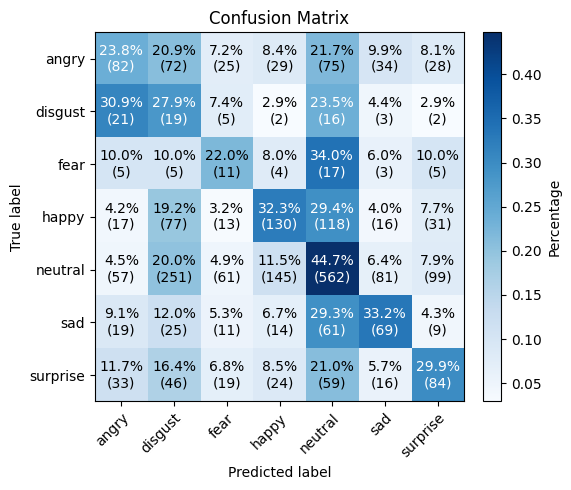

In [18]:
print(classification_report(meld_test['label'], [i[0][0] for i in meld_test['fused_no_face']]))
plot_confusion_matrix(meld_test['label'], [i[0][0] for i in meld_test['fused_no_face']])

              precision    recall  f1-score   support

       angry       0.36      0.30      0.33       345
     disgust       0.13      0.18      0.15        68
        fear       0.12      0.26      0.16        50
       happy       0.37      0.39      0.38       402
     neutral       0.62      0.57      0.59      1256
         sad       0.32      0.37      0.34       208
    surprise       0.32      0.37      0.34       281

    accuracy                           0.45      2610
   macro avg       0.32      0.35      0.33      2610
weighted avg       0.47      0.45      0.46      2610



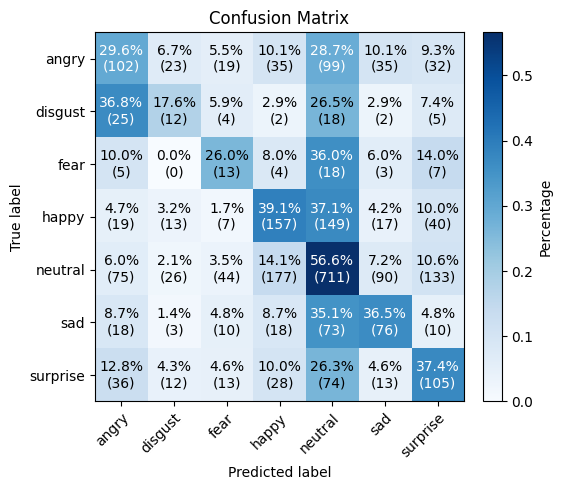

In [19]:
print(classification_report(meld_test['label'], [i[1][0] for i in meld_test['fused_no_face']]))
plot_confusion_matrix(meld_test['label'], [i[1][0] for i in meld_test['fused_no_face']])

In [ ]:
from src.evaluation import plot_confusion_matrix
from sklearn.metrics import classification_report


def safe_float_dict(d):
    """Convert dict values to float if they are strings."""
    if isinstance(d, dict):
        return {k: float(v) for k, v in d.items()}
    return d

def get_final_pred(preds):
    audio_emo, face_emo, text_emo = preds

    # Ensure numeric values
    audio_emo = safe_float_dict(audio_emo)
    text_emo = safe_float_dict(text_emo)
    face_emo = [safe_float_dict(i['emotions']) for i in face_emo]

    tav_input = {'audio': audio_emo, 'video': face_emo, 'text': text_emo}
    ta_input = {'audio': audio_emo, 'text': text_emo}

    pred_tav = fusion.fuse(tav_input)
    pred_ta = fusion.fuse(ta_input)

    return (pred_tav, pred_ta)



#meld_test['fused'] = meld_test['preds'].progress_apply(get_final_pred)


100%|██████████| 2610/2610 [00:00<00:00, 58613.54it/s]


In [ ]:
meld_test['final_fer'] = meld_test['preds'].apply(lambda x: x['frames']=x)
meld_test['final_fer'] = meld_test['fused'].apply(lambda x: x[0][0])
print(classification_report(meld_test['label'], meld_test['final_fer']))
plot_confusion_matrix(meld_test['label'], meld_test['final_fer'])

In [ ]:
meld_test['final_tav'] = meld_test['fused'].apply(lambda x: x[0][0])
meld_test['final_ta'] = meld_test['fused'].apply(lambda x: x[1][0])

              precision    recall  f1-score   support

       angry       0.35      0.21      0.26       345
     disgust       0.04      0.37      0.07        68
        fear       0.08      0.20      0.11        50
       happy       0.36      0.33      0.34       402
     neutral       0.61      0.42      0.50      1256
         sad       0.31      0.30      0.31       208
    surprise       0.31      0.27      0.29       281

    accuracy                           0.35      2610
   macro avg       0.30      0.30      0.27      2610
weighted avg       0.46      0.35      0.39      2610



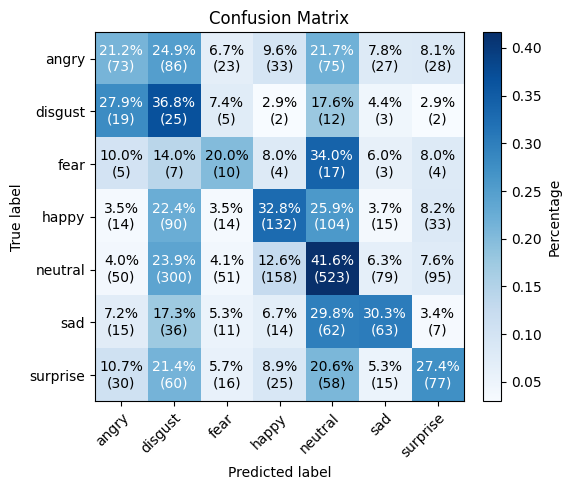

In [7]:
print(classification_report(meld_test['label'], meld_test['final_tav']))
plot_confusion_matrix(meld_test['label'], meld_test['final_tav'])

              precision    recall  f1-score   support

       angry       0.36      0.30      0.33       345
     disgust       0.13      0.18      0.15        68
        fear       0.12      0.26      0.16        50
       happy       0.37      0.39      0.38       402
     neutral       0.62      0.57      0.59      1256
         sad       0.32      0.37      0.34       208
    surprise       0.32      0.37      0.34       281

    accuracy                           0.45      2610
   macro avg       0.32      0.35      0.33      2610
weighted avg       0.47      0.45      0.46      2610



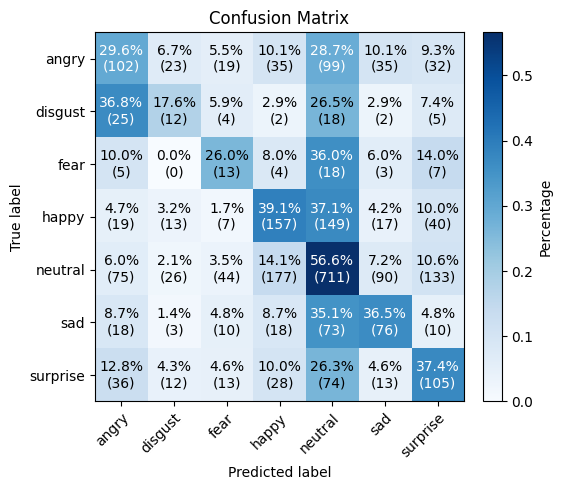

In [8]:
print(classification_report(meld_test['label'], meld_test['final_ta']))
plot_confusion_matrix(meld_test['label'], meld_test['final_ta'])

## IEMOCAP

In [9]:
from src.data_loading import load_iemocap
iemocap = filter_emotions(load_iemocap())

iemocap['preds'] = iemocap['filename'].progress_apply(multimodal_er)
iemocap.to_csv("iemocap_test_late_fusion_preds.csv", index=False)

  0%|          | 1/4639 [00:02<3:16:34,  2.54s/it]


KeyError: 'frames'

In [ ]:
iemocap['final_tav'] = iemocap['fused'].apply(lambda x: x[0][0])
iemocap['final_ta'] = iemocap['fused'].apply(lambda x: x[1][0])

## One example

In [6]:
file_data = fp.process_file(meld_test.iloc[0]['filename'])

MoviePy - Writing audio in /var/folders/ry/9hpdp04n0n58r6p626cfk2gh0000gn/T/tmpn673r9j3.wav


MoviePy - Done.


In [7]:
audio_emo = audio_recognizer.analyze(file_data["audio"]['raw'], 16000)
audio_emo

'neutral'

In [ ]:
face_emo = vision_recognizer.analyze_video_frames(file_data["frames"])
face_emo

Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 36.88it/s]


[{'emotions': {'angry': 0.0,
   'disgust': 1.4464581326036336e-20,
   'fear': 100.0,
   'happy': 0.0,
   'sad': 2.8519372627378026e-09,
   'surprise': 7.247253280605571e-33,
   'neutral': 6.12351934245215e-14},
  'dominant_emotion': 'fear'},
 {'emotions': {'angry': 1.6297385589751985e-24,
   'disgust': 99.99915361404419,
   'fear': 0.0008520142728229985,
   'happy': 2.2368856805416004e-33,
   'sad': 9.684274576756216e-20,
   'surprise': 7.769576801533988e-28,
   'neutral': 0.0},
  'dominant_emotion': 'disgust'},
 {'emotions': {'angry': 4.301996736551802e-28,
   'disgust': 3.0873564121902675e-09,
   'fear': 76.4445424079895,
   'happy': 6.049487318578226e-25,
   'sad': 23.55545461177826,
   'surprise': 6.61364265865379e-25,
   'neutral': 3.2184810158495156e-15},
  'dominant_emotion': 'fear'}]

In [ ]:
text_emo = text_recognizer.analyze(file_data["text"])
text_emo

'neutral'

In [ ]:
preds = {
    'text': text_emo,
    'audio': audio_emo,
    'video': [i['emotions'] for i in face_emo]
}
label, probs, top3 = fusion.fuse(preds)
print("🎯 Final label:", label)
print("📊 Probabilities:", probs)
print("🏆 Top-3:", top3)

🎯 Final label: neutral
📊 Probabilities: {'neutral': 0.41382028391121123, 'happy': 0.30037473039789314, 'angry': 0.0010982991114847306, 'disgust': 5.855429157193812e-07, 'fear': 0.1232582616366992, 'sad': 0.161407970860896, 'surprise': 3.986853890003523e-05}
🏆 Top-3: [('neutral', 0.41382028391121123), ('happy', 0.30037473039789314), ('sad', 0.161407970860896)]


In [10]:
meld_test

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename,label
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",/Users/sofiafernandes/.cache/kagglehub/dataset...,surprise
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",/Users/sofiafernandes/.cache/kagglehub/dataset...,angry
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",/Users/sofiafernandes/.cache/kagglehub/dataset...,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,2760,"Yeah, I mean, come on Ross, no one will even n...",Rachel,neutral,neutral,279,11,6,4,"00:14:35,457","00:14:40,211",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
2606,2761,They’re not listening too me?,Ross,surprise,negative,279,12,6,4,"00:14:42,256","00:14:43,840",/Users/sofiafernandes/.cache/kagglehub/dataset...,surprise
2607,2762,Of course they’re listening to you! Everybody ...,Rachel,neutral,neutral,279,13,6,4,"00:14:44,008","00:14:48,511",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
2608,2763,Monica you really think I should try this phas...,Ross,neutral,neutral,279,14,6,4,"00:14:48,138","00:14:52,390",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
